# Classifying urban sounds using deep learning models.
## Data preprocessing
### Properties to be normalized:
During exploration it was found that the following properties needed normalization:
 - Audio channel number.
 - Sample Rate
 - Bit Depth
 
 Much of the preprocessing can be done via Librosa's load() function. The output of this function will be compared against the default parameters of scipy's wavefile library which will output original properties.

Original sample rate: 44100
Resampled rate: 22050
Original file min/max range:  -17550  to  15878
Resampled file min/max range:  -0.46296388  to  0.44511634



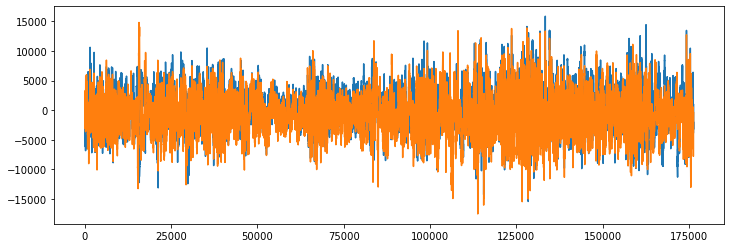

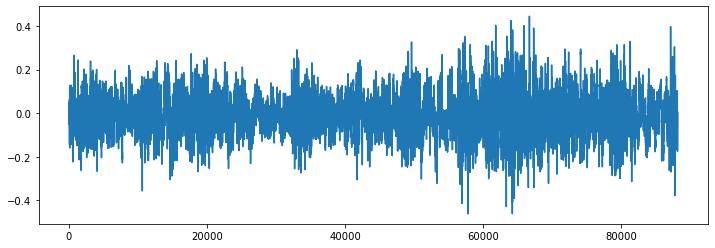

In [23]:
import librosa
from scipy.io import wavfile as wav
import numpy as np
import matplotlib.pyplot as plt



def preprocess_file(file):
    #sample rate conversion
    libro_audio, libro_sr = librosa.load(file)
    scipy_sr,scipy_audio = wav.read(file)
    print('Original sample rate:',scipy_sr)
    print('Resampled rate:',libro_sr)
    
    #bit depth converstion
    print('Original file min/max range: ',np.min(scipy_audio),' to ',np.max(scipy_audio))
    print('Resampled file min/max range: ',np.min(libro_audio),' to ',np.max(libro_audio))
    
    #Combining audio channels
    plt.figure(figsize=(12, 4))
    plt.plot(scipy_audio)
    print('')
    plt.figure(figsize=(12, 4))
    plt.plot(libro_audio)
    
    return libro_audio,libro_sr,scipy_audio,scipy_sr
    
libro_audio,libro_sr,scipy_audio,scipy_sr = preprocess_file('D:/udacity_mlnd_capstone/data/UrbanSound8K/audio/fold8/14386-9-0-6.wav')
    

## Feature Extraction
As mentioned in the proposal, we will extract [Mel-Frequency Cepstral Coefficients (MFCC)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) from the the audio samples. 

The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

### Extracting a MFCC

In [24]:
mfccs = librosa.feature.mfcc(y=libro_audio, sr=libro_sr, n_mfcc=40)
print(mfccs.shape)

(40, 173)


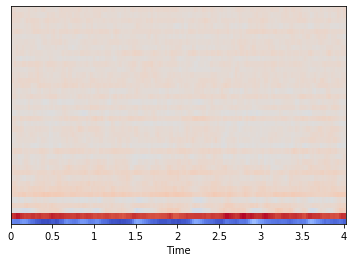

In [25]:
import librosa.display
librosa.display.specshow(mfccs, sr=libro_sr, x_axis='time')

### Extracting MFCC's from the dataset
The MFCC for each file is extracted and saved into a dataframe along with its label. Their sizes are also normalized since neural networks require fixed sized data.

In [26]:
#This function extrcts MFCCs for a single file.
def extract_features(index,row):
    file = os.path.join(os.path.abspath(BASE_PATH+'data/urbansound8k/audio'),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    label =  row['class']
    max_padding = 175
    try:
        audio, sr = librosa.load(file, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        pad_width = max_padding - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print(e,file)
        return None
     
    return [mfccs,file]
        

In [30]:
%%time

import librosa
import os
import pandas as pd
import concurrent.futures
from tqdm.notebook import tqdm

BASE_PATH = 'D:/udacity_mlnd_capstone/'

metadata = pd.read_csv(BASE_PATH+'data/urbansound8k/metadata/UrbanSound8k.csv')
features =[]

with concurrent.futures.ThreadPoolExecutor() as exe:#multithreaded run of the function
    #lambda function was used to pass multiple args to the function
    features = list(tqdm(exe.map(lambda p:extract_features(*p),metadata.iterrows()),total=len(metadata),leave=None))

# Convert into pandas dataframe
features_df = pd.DataFrame(features,columns=['features', 'class'])


Wall time: 3min 48s


### Convert data and labels
Categorical text data in the labels is encoded into numerical format because most machine learning models only work on numerical data. The module used here is the `sklearn.preprocessing.LabelEncoder`. The labels are also being designated as categorical using `keras.utils.to_cetegorical`. This ensures that the model does no find any mathematical features.

In [42]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

X = np.array(features_df['features'].tolist())
y = np.array(features_df['class'].tolist())

encoder = LabelEncoder()
cat_y = to_categorical(encoder.fit_transform(y))

### Saving dataset for later use

In [72]:
import pickle

out_path = 'data\\dataset.npz'
np.savez(out_path,features=X,labels=y)